# Entanglement detection

In [3]:
## import necessary packages
import sys
import numpy as np
import matplotlib as mpl
import math
from cmath import cos, sin, exp, pi, sqrt
# import cmath

# mpl.rcParams['figure.dpi'] = 400
# mpl.rcParams["figure.figsize"] = [10, 6]
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# print(sys.version)
# print(sys.executable)
# print(np.__version__)
# print(mpl.__version__)

from qutip import *

import random
pauli_operators = [qeye(2), sigmax(),sigmay(),sigmaz()]
I, X, Y, Z = qeye(2), sigmax(), sigmay(), sigmaz()

from sklearn import svm, datasets
from sklearn.inspection import DecisionBoundaryDisplay



## Entanglement witness

### Dataset generation

In [90]:
def generate_rand_product_state(n,m):
    print("----- generate_rand_product_state -----")
    print("number of qubits: ", n, "; number of samples: ", m)
    # print("number of samples: ", m)
    return [
        ket2dm( tensor([ rand_ket(2) for j in range(n) ]) ) for i in range(m)
    ]


# def generate_rand_3_qubit_pure_product_state(d, m):
#     return [
#         ket2dm(tensor(rand_ket(2), rand_ket(2), rand_ket(2))) for i in range(m)
#     ]


# def generate_two_qubit_product_pure_state(m):
#     return [ tensor([rand_ket(N=2),rand_ket(N=2)]) for i in range(m) ]

# def generate_two_qubit_entangled_pure_state(m):

def ppt_criterion(rho):
    # Necessary and sufficient condition (2-qubit): Positive Partial Transpose (PPT)
    rho_out = partial_transpose(rho, [0, 1])
    smallest_eigenval = rho_out.eigenenergies(sort='low', eigvals=1)
    # print(rho_out.eigenenergies(sort='low',eigvals=1))
    return smallest_eigenval

def generate_two_qubit_random_state_PPT(m):
    rand_dm_2 = [rand_dm(N=4, dims=[[2, 2], [2, 2]]) for i in range(m)]
    entangled = list(filter(lambda p: ppt_criterion(p) < 0, rand_dm_2))
    # for product pure states, the smallest eigenvalue is a very very small negative one
    separable = list(filter(lambda p: ppt_criterion(p) >= 0, rand_dm_2))
    print('number of entangled state:', len(entangled))
    print('number of separable state:', len(separable))

    smallest_eigen_list_random = np.array([ ppt_criterion(state)
     for state in rand_dm_2
    ]).flatten()

    # fig, ax = plt.subplots(figsize=(6, 4))

    # # print(np.array(smallest_eigen_list_entangled).flatten())
    # # ax.hist(smallest_eigen_list_random)
    # ax.hist([e for e in smallest_eigen_list_random if e < 0])
    # ax.hist([e for e in smallest_eigen_list_random if e >= 0])
    # # ax.text(4, 0.4, r'$$')
    # ax.set_ylabel('Samples')
    # ax.set_xlabel('smallest eigenvalue of partial transpose')
    # ax.set_title('2-qubit random density matrix (test PPT criterion)')

    # plt.savefig('two_qubit_PPT_hist.png', dpi=300)

    return [entangled, separable]

# for state in generate_two_qubit_entangled_pure_state(3):
#     eigen_val = ppt_criterion(state)
#     eigen_val
# print(rand_dm(N=4,dims=[[2,2],[2,2]]) )

# generate_two_qubit_random_state_PPT(1000)
# [ppt_criterion(dm) for dm in [ket2dm(ket) for ket in generate_two_qubit_product_pure_state(100)]]
# [ppt_criterion(dm) for dm in generate_bell_like_pure_state(10)]


def generate_bell_noisy_density(m, kind):
    # p_limit = 1/3
    random_white_noise_p = [random.random() / 3 for i in range(m)]

    # density_matrix_bell00 = ket2dm( bell_state(state=k) )
    # print(density_matrix_bell00)

    # noisy_density = density_matrix_bell00* (1 - p) +  p /4 * identity([2,2])
    # print(noisy_density)
    return [
        ket2dm(bell_state(state=kind)) * (1 - p) + p / 4 * identity([2, 2])
        for p in random_white_noise_p
    ]


def generate_bell_like_pure_state(m):
    # permute(order)
    theta_list = [ random.random()*2*pi for i in range(m) ]
    phi_list = [ random.random()*pi for i in range(m) ]

    a_list = [ cos(theta) for theta in theta_list ]
    b_list = [ sin(theta) * exp(phi*1j) for theta in theta_list for phi in phi_list ]
    # x = a* basis(4, 0) + b* basis(4, 3)
    # print(x.norm())
    # print(x)
    # print(x.isket)

    return [ket2dm( a* tensor(basis(2, 0),basis(2, 0)) + b* tensor(basis(2, 1),basis(2, 1)) ) for a in a_list for b in b_list ]

def generate_noisy_ghz_ensemble(n,m,noise_limit):
    return  [ket2dm(ghz_state(N=n)) * (1 - p_noise) +  p_noise / (2**n) * qeye([2 for j in range(n)]) for p_noise in [random.random()*noise_limit for i in range(m)] ]


def generate_noisy_w_ensemble(n, m, noise_limit):
    return [
        ket2dm(w_state(N=n)) * (1 - p_noise) + p_noise /
        (2**n) * qeye([2 for j in range(n)])
        for p_noise in [random.random() * noise_limit for i in range(m)]
    ]
# bell_like_pure_state = generate_bell_like_pure_state(10, False)

# generate_rand_product_state(4,3)

### Visualize dataset samples

----- generate_rand_product_state -----
number of qubits:  2 ; number of samples:  100


(array([ 2.,  1.,  2.,  2.,  7., 17., 18., 20., 20., 11.]),
 array([-3.84259813e-16, -3.42590202e-16, -3.00920590e-16, -2.59250979e-16,
        -2.17581367e-16, -1.75911755e-16, -1.34242144e-16, -9.25725323e-17,
        -5.09029208e-17, -9.23330923e-18,  3.24363023e-17]),
 <BarContainer object of 10 artists>)

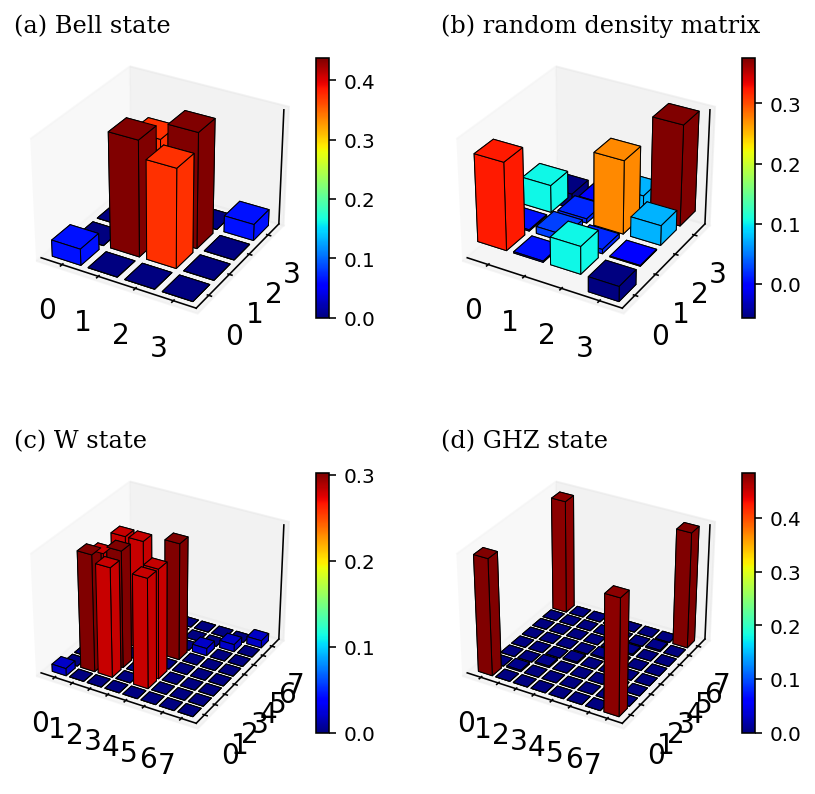

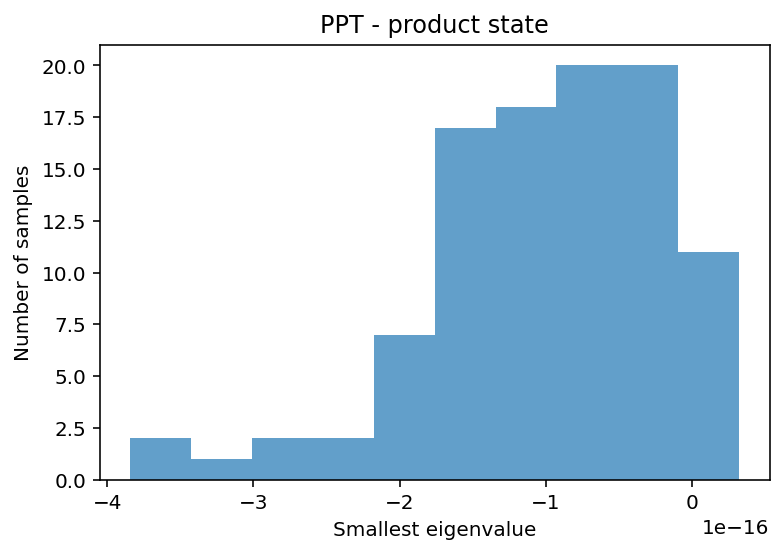

In [94]:
size_train = 10

# visualization
# fig = plt.figure(figsize=plt.figaspect(0.5))
fig = plt.figure(figsize=(7, 7))
# fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set_title('(a) Bell state', fontfamily='serif', loc='left', fontsize='large')
matrix_histogram(random.choice(generate_bell_noisy_density(m=size_train,kind='10')), fig=fig, ax=ax)
# xlabels=['00', '01', '10', '11'],
# ylabels=['00', '01', '10', '11'],
# title="a random two qubit entangled state",

# set up the axes for the second plot
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.set_title('(b) random density matrix', fontfamily='serif', loc='left', fontsize='large')
matrix_histogram(random.choice([rand_dm(N=4, dims=[[2, 2], [2, 2]]) for i in range(size_train)]), fig=fig, ax=ax)

# W
w_3_density = generate_noisy_w_ensemble(3,size_train,1/3)
# set up the axes for the first plot
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.set_title('(c) W state', fontfamily='serif', loc='left', fontsize='large')
matrix_histogram(random.choice(w_3_density), fig=fig, ax=ax)

# GHZ
ghz_3_density = generate_noisy_ghz_ensemble(3,size_train,1/3)
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.set_title('(d) GHZ state', fontfamily='serif', loc='left', fontsize='large')
matrix_histogram(random.choice(ghz_3_density), fig=fig, ax=ax)

plt.savefig('dataset_sample.png', dpi=300)

fig, ax = plt.subplots(figsize=(6, 4))

smallest_eigen_list_entangled = [ ppt_criterion(state) for state in generate_rand_product_state(2,100) ]
# print(smallest_eigen_list_entangled)
# print(np.array(smallest_eigen_list_entangled).flatten())
ax.set_ylabel('Number of samples')
ax.set_xlabel('Smallest eigenvalue')
ax.set_title('PPT - product state')
ax.hist(np.array(smallest_eigen_list_entangled), alpha=0.7)



In [ ]:
# some visualization

# Schmidt decomposition
# plot_schmidt(w_state(3), splitting=2, labels_iteration=(3, 2), theme='light', fig=None, ax=None, figsize=(6, 6))

# bell state
# bell_state(state='00')
# singlet_state()

# b = Bloch()
# # pnt = [1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)]
# # b.add_points(pnt)
# b.add_states([rand_ket(2) for i in range(200)])
# b.render()
# b.show()

### machine learning ansatz

In [75]:
# size_train = 100
# size_test = 10

# rigorous witness

# Bell inequality

# machine learning ansatz

# w_ansatz = tensor([sigmax(), sigmax(), sigmaz()])
# print(w_ansatz)


### 2-qubit case

In [117]:
def construct_training_dataset(states,labels,operators):
    print("====== construct_training_dataset =======")
    all_states =  sum(states, [])
    features = [
        expect(operators, state) for state in all_states
        # from functools import reduce
        # for state in reduce(lambda x, y: x + y, states)
    ]
    y = np.array(labels).flatten()
    print("number of samples: ", len(all_states), "; number of labels: ", len(y), '; dimension: ', shape(features))
    return (features, y)

# number_samples = 1000
size_train = 3

bell_kinds = ['00', '01', '10', '11']
two_pauli = [tensor([a,b]) for a in pauli_operators for b in pauli_operators ]
# print(two_pauli)

# print(expect(two_pauli,bell_state('11')))
X_0 = generate_bell_noisy_density(size_train,kind='11')
y_0 = [0 for i in range(size_train)]
X_1 = generate_rand_product_state(n=2,m=size_train)
y_1 = [1 for i in range(size_train)]
X, y = construct_training_dataset([X_0, X_1], [y_0, y_1],two_pauli)
# X
# y

----- generate_rand_product_state -----
number of qubits:  2 ; number of samples:  3
====== construct_training_dataset =======
number of samples:  6 ; number of labels:  6 ; dimension:  (6, 16)


----- generate_rand_product_state -----
number of qubits:  2
number of samples:  1000
============== summary ===============
size of training set: 5000 ; size of testing set: 1000
kernel method: rbf
1.0
accuracy of prediction 0 (bell entangled): 1.0
----- generate_rand_product_state -----
number of qubits:  2
number of samples:  1000
accuracy of prediction 1 (separable): 1.0
[0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1
 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 1 0

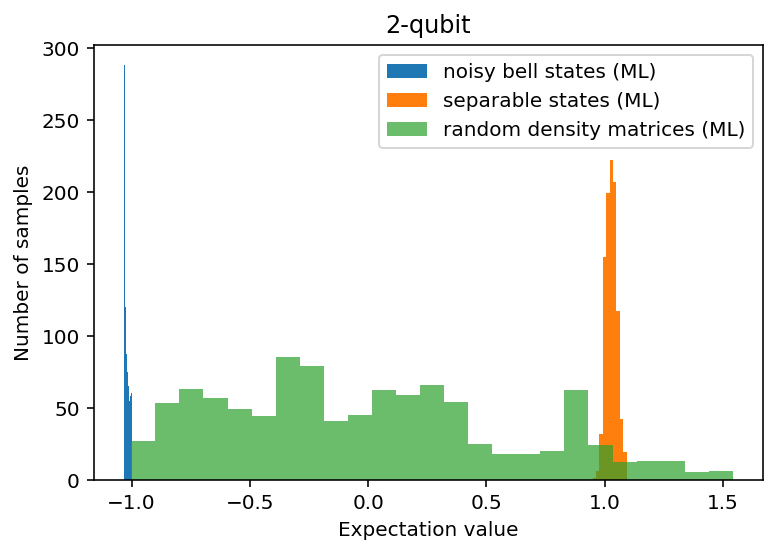

In [78]:
# rand_herm
# rand_unitary
# rand_unitary_haar
# rand_dm(N=3)

# traing with the entries of the density matrix


# generate_rand_pure_state_ensemble(4,5)
def assemble_training_dataset(m):

    # figure = plt.figure(figsize=(10, 6))
    # fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
    # fig, axes = plt.subplots(1, 2, figsize=(12,3))
    # bell_noisy_density = np.array([ generate_bell_noisy_density(m, kind) for kind in bell_kinds ]).flatten()
    # print(len(bell_noisy_density))
    # print(bell_noisy_density[3])
    bell00_noisy_density = generate_bell_noisy_density(m,'00')
    # print(bell00_noisy_density[0])
    bell01_noisy_density = generate_bell_noisy_density(m,'01')
    bell10_noisy_density = generate_bell_noisy_density(m,'10')
    bell11_noisy_density = generate_bell_noisy_density(m,'11')

    # generate_two_qubit_product_pure_state(m)
    # feature_bell = [ expect(two_pauli, state) for state in flatten(bell_noisy_density) ]
    # print(feature_bell)
    feature_bell00 = [
        expect(two_pauli, state) for state in bell00_noisy_density
    ]
    feature_bell01 = [
        expect(two_pauli, state) for state in bell01_noisy_density
    ]
    feature_bell10 = [
        expect(two_pauli, state) for state in bell10_noisy_density
    ]
    feature_bell11 = [
        expect(two_pauli, state) for state in bell11_noisy_density
    ]

    # ax = plt.subplot(1,2,1)
    # visualize a random noisy Bell state in density matrix


    separable_pure_state = generate_rand_product_state(n=2,m=m)
    feature_separable = [
     expect(two_pauli, state)
     for state in separable_pure_state
    ]
    # visualize a random pure product state in density matrix
    # matrix_histogram( ket2dm(random.choice(separable_pure_state)) )

    # combine 0 data with 1 data
    feature = feature_bell00 + feature_bell01 + feature_bell10 + feature_bell11 + feature_separable

    label = [0 for i in range(m)] + [0 for i in range(m)]+ [0 for i in range(m)]+ [0 for i in range(m)] + [1 for i in range(m)]
    return (feature, label)

# def my_predict(x, ax):

def my_svm(x, y, size_train, size_test, kernel):
    ################# SVM training ####################
    print("============== summary ===============")
    print("size of training set:", len(x), "; size of testing set:", size_test)
    # print("size of testing set:", size_test)

    # we create an instance of SVM and fit out data.
    if kernel == 'linear':
        # linear kernel
        print("kernel method: linear kernel")
        clf = svm.SVC(kernel='linear')
        # clf = svm.SVC(kernel=my_kernel)
        # # clf.get_params()
        clf.fit(X, Y)
        print(clf.score)
        print(clf.coef0)
        print(clf.coef_)
        print(clf.intercept_)
    else:
        # kernel
        print("kernel method: rbf")
        clf = svm.SVC()
        clf.fit(X, Y)
        print(clf.score(X, Y))
        # print(clf.score)

    fig, ax = plt.subplots(figsize=(6, 4))

    ################# test/prediction ####################
    test_0 = generate_bell_noisy_density(int(size_test/4),'00') + generate_bell_noisy_density(int(size_test/4),'01') + generate_bell_noisy_density(int(size_test/4),'10') + generate_bell_noisy_density(int(size_test/4),'11')
    prediction_0 = clf.predict([expect(two_pauli, state) for state in test_0 ])
    decision_0 = clf.decision_function([ expect(two_pauli, state) for state in test_0 ])
    print("accuracy of prediction 0 (bell entangled):", sum((1-prediction_0))/len(prediction_0))
    # print(prediction)
    ax.hist(decision_0)

    test_1 = generate_rand_product_state(n=2,m=size_test)
    # test_1 = generate_two_qubit_random_pure_state_PPT(size_test)[1]
    feature_1 = [ expect(two_pauli, state) for state in test_1 ]
    prediction_1 = clf.predict(feature_1)
    print("accuracy of prediction 1 (separable):", sum(prediction_1)/len(prediction_1))
    decision_1 = clf.decision_function(feature_1)
    ax.hist(decision_1)

    test_2 = generate_bell_like_pure_state(10)
    # test_2 = generate_two_qubit_random_state_PPT(size_test)[0]
    feature_2 = [ expect(two_pauli, state) for state in test_2 ]
    prediction_2 = clf.predict(feature_2)
    print(prediction_2)
    decision_2 = clf.decision_function(feature_2)
    ax.hist(decision_2, alpha=0.7, bins=25)
    print("accuracy of prediction (other entangled):", sum(prediction_2)/len(prediction_2))

    # ax.hist([expect(state, bell_inequality) for state in test_0 ])
    # ax.hist([expect(state, bell_inequality) for state in [ ket2dm(ket) for ket in test_1 ] ])
    # ax.hist([expect(state, bell_inequality) for state in test_2 ])

    print("============== end ===============")
    ax.set_ylabel('Number of samples')
    ax.set_xlabel('Expectation value')
    ax.set_title('2-qubit')
    ax.legend(('noisy bell states (ML)', 'separable states (ML)',
           'random density matrices (ML)', 'bell inequality'),
          loc='upper right')
    plt.savefig('two_qubit_hist.png', dpi=300)


(X, Y) = assemble_training_dataset(size_train)
my_svm(X, Y, 1000, 1000, 'rbf')
# my_svm(X, Y, 1000, 100, 'linear')

number of entangled state: 6
number of separable state: 4
[array([ 1.        , -0.17923605,  0.0589238 ,  0.20698304, -0.09774684,
       -0.02552989, -0.05353651,  0.5401004 ,  0.39872061, -0.14907447,
        0.23371939,  0.1894432 ,  0.04557272,  0.2895322 ,  0.03624518,
       -0.18642212]), array([ 1.        , -0.27188507, -0.54884878,  0.24995544, -0.25274887,
       -0.19476659,  0.24193446, -0.20534872,  0.00479267, -0.09647647,
       -0.14355671,  0.18498614,  0.05441497, -0.06066872, -0.33616752,
       -0.54524947]), array([ 1.        ,  0.22481066, -0.1034418 , -0.44786644, -0.10407508,
       -0.20705649,  0.49695974,  0.07345519, -0.12050952,  0.00462816,
        0.06808532, -0.0709427 ,  0.18607112,  0.41440933, -0.37222065,
       -0.01961989]), array([ 1.        ,  0.63913889, -0.30380413,  0.03026374,  0.11440237,
        0.20127084,  0.30295569,  0.01698168,  0.24153406, -0.00238378,
       -0.1520845 ,  0.27749268, -0.58399832, -0.72007309,  0.14015527,
       -0.1

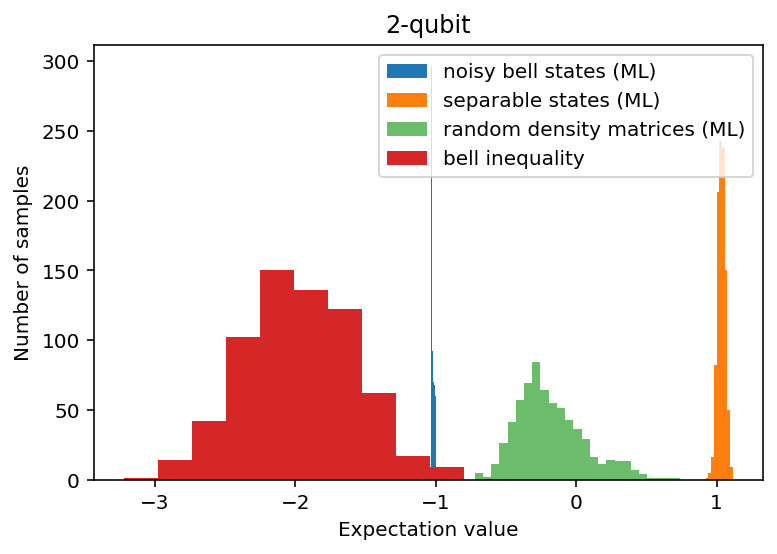

In [49]:
two_qubit_random_pure_state = generate_two_qubit_random_state_PPT(10)
entangled_sample = two_qubit_random_pure_state[0]
feature_entangled = [ expect(two_pauli, state) for state in entangled_sample ]
# print(len(entangled_sample))
print(feature_entangled)
separable_sample = two_qubit_random_pure_state[1]
feature_separable = [expect(two_pauli, state) for state in separable_sample]
# print(len(separable_sample))
labels = [0 for i in range(len(entangled_sample))]+ [1 for i in range(len(separable_sample))]

my_svm(feature_entangled + feature_separable, labels, 1000, 1000, 'rbf')


### Bell, CHSH inequalities as entanglement witness

the Bell inequality
$$ \langle a_0b_0, a_0b_0', a_0'b_0, a_0'b_0' \rangle$$
with $a_0=\sigma_x$, $a_0'=\sigma_x$, $b_0=(\sigma_x-\sigma_z)/\sqrt{2}$, and $b_0'=(\sigma_x+\sigma_z)/\sqrt{2}$

the CHSH inequality
$$ \langle \rangle$$


In [51]:
a_0 = sigmaz()
a_1 = sigmax()
b_0 = (sigmax() - sigmaz() )/sqrt(2)
b_1 = (sigmax() + sigmaz())/sqrt(2)
bell_ansatz = [ tensor(a_0,a_1), tensor(a_1,b_0), tensor(a_1,b_1), -tensor(a_0,b_1) ]
bell_inequality = tensor(a_0,a_1) + tensor(a_1,b_0) + tensor(a_1,b_1) - tensor(a_0,b_1) 


In [ ]:
# expect(oper, state)
variance(oper, state)
# purity()

entropy_relative(rho, sigma, base=2.718281828459045, sparse=False, tol=1e-12)
entropy_vn(rho, base=2.718281828459045, sparse=False)
tracedist(A, B, sparse=False, tol=0)

measure(state, ops, targets=None)
measure_observable(state, op, targets=None)

# covariance_matrix(basis, rho, symmetrized=True)
# logarithmic_negativity(V, g=1.4142135623730951)

# dag(A)
# ptrace()
# flatten(l)
# partial_transpose(rho, mask, method='dense')

##### Two-qutrit

##### Two-qudit


In [345]:
# qutrit_basis()
x = basis(3, 2)
M = ket2dm(x)
print(M)


### Three-qubit case
fully separable

biseparable

GME

----- generate_rand_product_state -----
number of qubits:  3
number of samples:  1000
----- generate_rand_product_state -----
number of qubits:  3
number of samples:  1000
----- generate_rand_product_state -----
number of qubits:  3
number of samples:  2000
1.0
----- generate_rand_product_state -----
number of qubits:  3
number of samples:  1000


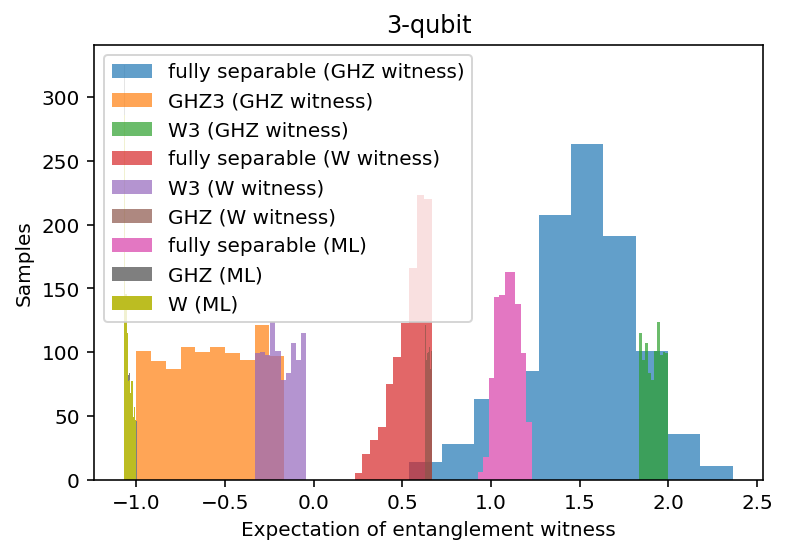

In [80]:
size_train = 1000
size_test = 1000

# three-qubit tomographic ansatz
three_pauli = [tensor([a,b,c]) for a in pauli_operators for b in pauli_operators for c in pauli_operators]

# GHZ
ghz_3_density = generate_noisy_ghz_ensemble(n=3,m=size_train,noise_limit=1/3)
# W
w_3_density = generate_noisy_w_ensemble(n=3,m=size_train,noise_limit=1/3)


fig, ax = plt.subplots(figsize=(6, 4))

# rigorous entanglement witness - local measurements
witness_ghz_3 =  3/2 * qeye([2, 2, 2]) - tensor([sigmax(), sigmax(), sigmax()]) - 1/2 * (tensor([sigmaz(), sigmaz(), qeye([2])]) + tensor([qeye([2]), sigmaz(), sigmaz()]) + tensor([sigmaz(), qeye([2]), sigmaz()]))

# rigorous entanglement witness - projection
witness_w_3_project = 2/3 * qeye([2, 2, 2]) - ket2dm(w_state(N=3))

expect_fully_separable_3 = [
    expect(witness_ghz_3, state) for state in generate_rand_product_state(3,size_train)
]
ax.hist(expect_fully_separable_3, alpha=0.7)
# ax.plot(expect_fully_separable_3)

expect_witness_ghz_3 = [
 expect(witness_ghz_3, state) for state in ghz_3_density
]
ax.hist(expect_witness_ghz_3, alpha=0.7)
# ax.plot(expect_witness_ghz_3)

# witness_ghz_3_project = 1/2 * qeye([2, 2, 2]) - ket2dm(ghz_state(N=3))
# # print(witness_ghz_3_project)
# expect_witness_ghz_3_project = [
#  expect(witness_ghz_3_project, state) for state in ghz_3_density
# ]
# # print(expect_witness_ghz_3_project)
# ax.hist(expect_witness_ghz_3_project, alpha=0.7)
# # ax.plot(expect_witness_ghz_3_project)

# expect_witness_w_3_project = [
#  expect(witness_ghz_3_project, state) for state in w_3_density
# ]
# ax.hist(expect_witness_w_3_project, alpha=0.7, bins=10)

expect_ghz_witness_w_3 = [ expect(witness_ghz_3, state) for state in w_3_density ]
ax.hist(expect_ghz_witness_w_3, alpha=0.7, bins=10)

expect_fully_separable_3_w = [
    expect(witness_w_3_project, state) for state in generate_rand_product_state(n=3,m=size_train)
]
ax.hist(expect_fully_separable_3_w, alpha=0.7)

expect_w_witness_w_3 = [
    expect(witness_w_3_project, state) for state in w_3_density
]
ax.hist(expect_w_witness_w_3, alpha=0.7, bins=10)

expect_w_witness_ghz_3 = [
    expect(witness_w_3_project, state) for state in ghz_3_density
]
ax.hist(expect_w_witness_ghz_3, alpha=0.7, bins=10)

feature_ghz_3 = [expect(three_pauli, state) for state in ghz_3_density]
feature_w_3 = [expect(three_pauli, state) for state in w_3_density]
feature_product_3 = [
    expect(three_pauli, state)
    for state in generate_rand_product_state(3, 2 * size_train)
]

X = feature_ghz_3 + feature_w_3 + feature_product_3
Y = [0 for i in range(size_train)] + [0 for i in range(size_train)
                                      ] + [1 for i in range(2 * size_train)]
clf = svm.SVC()
clf.fit(X, Y)
print(clf.score(X, Y))

test_three_1 = generate_rand_product_state(3, size_test)
# test_1 = generate_two_qubit_random_pure_state_PPT(size_test)[1]
feature_three_1 = [expect(three_pauli, state) for state in test_three_1]
prediction_three_1 = clf.predict(feature_three_1)
# print(prediction_three_1)
decision_three_1 = clf.decision_function(feature_three_1)
ax.hist(decision_three_1)

test_three_ghz = generate_noisy_ghz_ensemble(n=3,m=size_test,noise_limit=1/3)
# test_1 = generate_two_qubit_random_pure_state_PPT(size_test)[1]
feature_three_ghz = [expect(three_pauli, state) for state in test_three_ghz]
prediction_three_ghz = clf.predict(feature_three_ghz)
# print(prediction_three_ghz)
decision_three_ghz = clf.decision_function(feature_three_ghz)
ax.hist(decision_three_ghz)

test_three_w = generate_noisy_w_ensemble(n=3,m=size_test,noise_limit=1/3)
# test_1 = generate_two_qubit_random_pure_state_PPT(size_test)[1]
feature_three_w = [expect(three_pauli, state) for state in test_three_w]
prediction_three_w = clf.predict(feature_three_w)
# print(prediction_three_w)
decision_three_w = clf.decision_function(feature_three_w)
ax.hist(decision_three_w)

# ax.text(4, 0.4, r'$$')
ax.set_ylabel('Samples')
# ax.set_ylabel(r'$ \tr (W \rho ) $')
ax.set_xlabel('Expectation of entanglement witness')
ax.set_title('3-qubit')
ax.legend(('fully separable (GHZ witness)', 'GHZ3 (GHZ witness)', 
           'W3 (GHZ witness)', 'fully separable (W witness)','W3 (W witness)', 'GHZ (W witness)', 'fully separable (ML)', 'GHZ (ML)', 'W (ML)'),
          loc='upper left')
# ax.legend(('fully separable (GHZ witness)', 'GHZ3 (GHZ witness)',
#            'GHZ3 (projection GHZ witness)', 'W3 (projection GHZ witness)',
#            'W3 (GHZ witness)', 'stabilizer', 'ML ansatz', 'bell inequality'),
#           loc='upper left')
# fig.show()
plt.savefig('three_qubit_hist.png', dpi=300)

# ansatz
three_pauli = [tensor([a,b,c]) for a in pauli_operators for b in pauli_operators for c in pauli_operators]


### Feature elimination

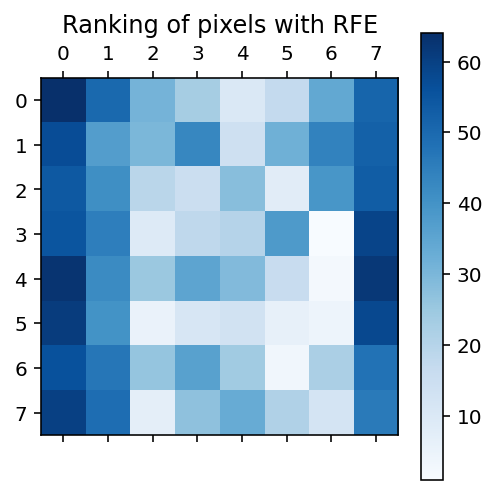

In [3]:
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py

from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

[False  True False  True False False False False False False]
[3 1 6 1 2 4 7 5 8 9]
score 0.5873850358814816
Selected features:


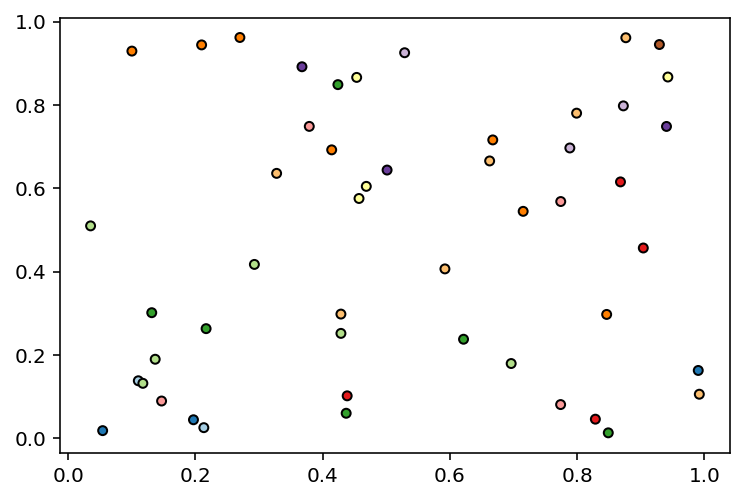

In [76]:
# https://www.datatechnotes.com/2021/03/recursive-feature-elimination-rfe.html

from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
# estimator = SVR(kernel="rbf", C=100)
estimator = SVR(kernel="linear", C=100)
selector = RFE(estimator=estimator, n_features_to_select=2, step=1)
selector = selector.fit(X, y)
filter = selector.support_
print(filter)
ranking = selector.ranking_.reshape(X[0].shape)
print(ranking)
print('score', selector.score(X, y))
# Reduce X to the selected features and predict using the estimator.
selector.predict(X)


print("Selected features:")
# print(X[:, filter])   
# print(y)
# print(X[0])
plt.scatter(X[:, filter][:, 0], X[:, filter][:, 1], c=y, zorder=10, cmap=plt.cm.Paired, edgecolor="k", s=20)

##### mixed state

Werner state

In [377]:
# plot_expectation_values(results, ylabels=[], title=None, show_legend=False, fig=None, axes=None, figsize=(8, 4))

# plot_wigner_sphere(fig, ax, wigner, reflections)

#### Four-qubit case

graph state - ring

2D cluster state

## Versions of software package/module 

In [25]:
# about()
# from qutip.ipynbtools import version_table
# version_table()
# qutip.cite()

# conda list

import sklearn
print(sklearn.__version__)

1.1.2


In [29]:
# https://vprusso.github.io/toqito/
from toqito.nonlocal_games.xor_game import XORGame

# The probability matrix.
prob_mat = np.array([[1/4, 1/4], [1/4, 1/4]])

# The predicate matrix.
pred_mat = np.array([[0, 0], [0, 1]])

# Define CHSH game from matrices.
chsh = XORGame(prob_mat, pred_mat)
chsh.classical_value()
chsh.quantum_value()

0.8535533908447781